# Explore here

### Paso 1: Carga del conjunto de datos

Cargar las librerias

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping


Cargar los datos y procesar las imágenes

In [6]:
data_dir = r"C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\data\raw\PetImages"

#Crear una función para acceder a las carpetas de imagenes y asignar etiquetas, a modo de identificar entre imagenes de perro y gato.

def load_and_preprocess_images(data_dir, target_size=(224, 224)):
    images = []
    labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                img_path = os.path.join(label_dir, filename)
                try:
                    img = image.load_img(img_path, target_size=target_size)
                    img_array = image.img_to_array(img)
                    img_array /= 255.0  # Normalizar los valores de píxeles
                    images.append(img_array)
                    # Asigna la etiqueta 0 para "Cat" y 1 para "Dog"
                    if label == "Cat":
                        labels.append(0)
                    elif label == "Dog":
                        labels.append(1)
                except Exception as e:
                    print(f"Error cargando la imagen {img_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(data_dir)

c:\Users\Dario Z\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


### Paso 2: Visualiza la información de entrada

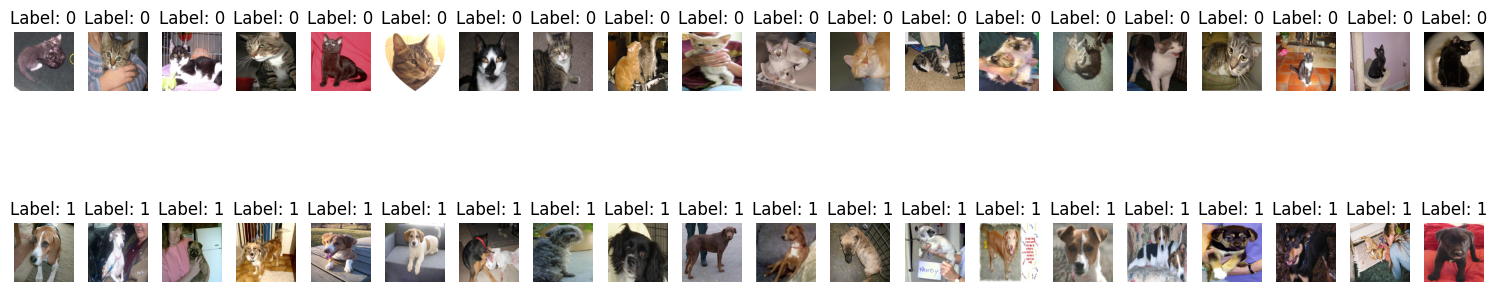

In [7]:
#Construir una funcion capaz de mostrar las imagenes cargadas en el paso anterior para corroborar que estén bien clasificadas, cargar una muestra de cada una


def visualize_sample_images(images, labels, num_samples=1):
    num_classes = np.max(labels) + 1
    plt.figure(figsize=(15, 5))

    for class_label in range(num_classes):
        class_indices = np.where(labels == class_label)[0]
        sample_indices = random.sample(list(class_indices), min(num_samples, len(class_indices)))
        
        for i, idx in enumerate(sample_indices, 1): 
            plt.subplot(num_classes, num_samples, class_label * num_samples + i)
            plt.imshow((images[idx] * 255).astype('uint8'))
            plt.title('Label: {}'.format(labels[idx]))
            plt.axis('off')

    plt.tight_layout()
    plt.show()

#Ejecutar la funcion para visualizar la muestra

visualize_sample_images(images, labels, num_samples=20)

Dividir los datos en Train y Test

In [8]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

from keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [9]:
#Es recomendado que la input shape del conjunto concuerde con el de la arquitectura. En este caso, 224,224,3

train_images.shape

(19967, 224, 224, 3)

In [10]:
# Generadores de datos de imagen para entrenamiento y prueba
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Train Generator

train_generator = train_datagen.flow(train_images, train_labels, batch_size=40)

# Test Generator
test_generator = test_datagen.flow(test_images, test_labels, batch_size=40)

### Paso 3: Construye una RNA

Arquitectura

In [11]:
model = Sequential()
model.add(Conv2D(input_shape = (224,224,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

Compilacion

In [12]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [13]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

## Paso 4: Optimiza el modelo anterior

Checkpoint y Early Stop

In [17]:
# Define el nombre del archivo para guardar el mejor modelo
checkpoint_filepath = r'C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models'

# Crea un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy', 
    save_best_only=True,  
    verbose=1  
)

# Crea un objeto EarlyStopping para detener el entrenamiento si no hay mejoras en el conjunto de validación
early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=2,  
    verbose=1,  
    restore_best_weights=True  
)

In [11]:
model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[model_checkpoint, early_stopping])

Epoch 1/5


1997/1997 [==============================] - ETA: 0s - loss: 257525510320569827145975595008.0000 - accuracy: 0.4989
Epoch 1: accuracy improved from -inf to 0.49887, saving model to C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models
INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


1997/1997 [==============================] - 6224s 3s/step - loss: 257525510320569827145975595008.0000 - accuracy: 0.4989 - val_loss: 0.6959 - val_accuracy: 0.5084
Epoch 2/5
1997/1997 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4966
Epoch 2: accuracy did not improve from 0.49887
1997/1997 [==============================] - 6177s 3s/step - loss: 0.6947 - accuracy: 0.4966 - val_loss: 0.6942 - val_accuracy: 0.4916
Epoch 3/5
1997/1997 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5027
Epoch 3: accuracy improved from 0.49887 to 0.50273, saving model to C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models
INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


1997/1997 [==============================] - 6140s 3s/step - loss: 0.6944 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4916
Epoch 4/5
1997/1997 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5031
Epoch 4: accuracy improved from 0.50273 to 0.50308, saving model to C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models
INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


INFO:tensorflow:Assets written to: C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\assets


1997/1997 [==============================] - 6340s 3s/step - loss: 0.6945 - accuracy: 0.5031 - val_loss: 0.6937 - val_accuracy: 0.5084
Epoch 5/5
1997/1997 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.4975
Epoch 5: accuracy did not improve from 0.50308
1997/1997 [==============================] - 6814s 3s/step - loss: 0.6946 - accuracy: 0.4975 - val_loss: 0.6936 - val_accuracy: 0.5084


In [5]:
#Juntar el modelo en un solo archivo porque me equivoque arriba con la ruta del checkpoint.

# Cargar la funcion load_model de keras
loaded_model = tf.keras.models.load_model(r'C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models')

# Guardar el modelo en un unico archivo .h5
loaded_model.save(r'C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\best_model.h5')

c:\Users\Dario Z\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Prediccion de modelo: Gato

1/1 [==============================] - 0s 340ms/step


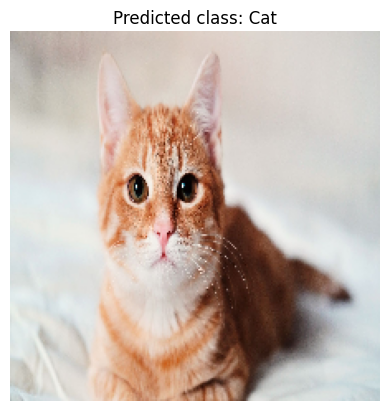

In [10]:
# Cargar el modelo
model = tf.keras.models.load_model(r'C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\best_model.h5')

# Cargar y preprocesar la imagen de prueba
img_path = r"C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\data\prediction\test_cat.jpg"
img = image.load_img(img_path, target_size=(224, 224)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0  # Normalizar el valor de los pixeles

# Hacer la prediccion
predictions = model.predict(img_array)

# Cargar las labels
class_labels = ['Cat', 'Dog']
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

# Mostrar la imagen junto con el label cargado
plt.imshow(img)
plt.axis('off')
plt.title("Predicted class: " + predicted_class_label)
plt.show()

Prediccion de modelo: Perro

1/1 [==============================] - 0s 160ms/step


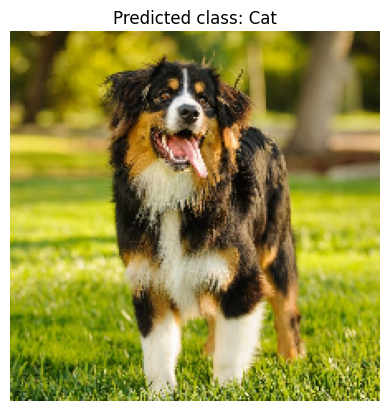

In [14]:
# Cargar y preprocesar la imagen de prueba
img_path = r"C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\data\prediction\test_dog.jpg"
img = image.load_img(img_path, target_size=(224, 224)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0  # Normalizar el valor de los pixeles

# Hacer la prediccion
predictions = model.predict(img_array)

# Cargar las labels
class_labels = ['Cat', 'Dog']
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

# Mostrar la imagen junto con el label cargado
plt.imshow(img)
plt.axis('off')
plt.title("Predicted class: " + predicted_class_label)
plt.show()

No funciona como corresponde

### Exploracion de las estadisticas del modelo

500/500 [==============================] - 350s 690ms/step


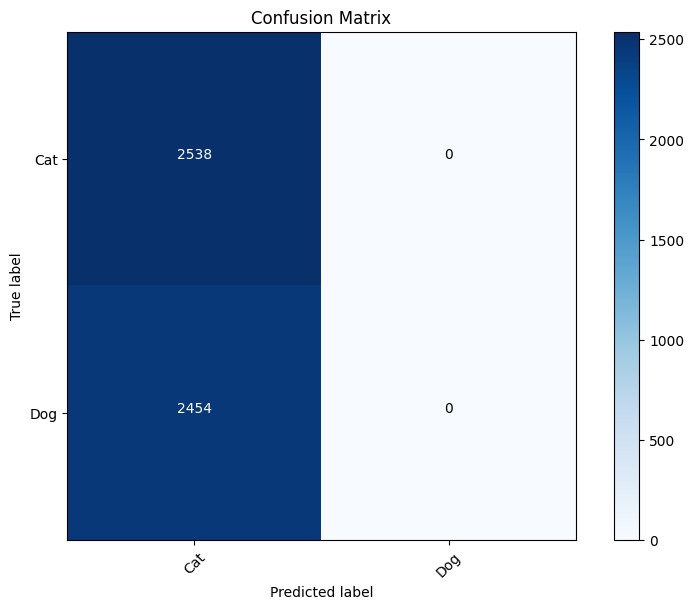

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Cargar el modelo

predictions = model.predict(test_generator)  # Reemplaza test_data con tus datos de prueba

# Convertir las predicciones de probabilidades a clases
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de datos de prueba
true_classes = np.argmax(test_labels, axis=1)  # Reemplaza test_labels con tus etiquetas verdaderas

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Definir las clases (etiquetas)
class_names = ['Cat', 'Dog'] 

# Mostrar la matriz de confusión
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

Hay un severo problema en la prediccion de imagenes

### Intentar corregir el modelo

Puede que el problema recaiga en la normalizacion de las imagenes, ya corregido el error, procedo a entrenar un nuevo  modelo resumido

In [14]:
# Define el nombre del archivo para guardar el mejor modelo
checkpoint_filepath = r'C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\corrected_model.h5'

# Crea un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy', 
    save_best_only=True,  
    verbose=1  
)

# Crea un objeto EarlyStopping para detener el entrenamiento si no hay mejoras en el conjunto de validación
early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=2,  
    verbose=1,  
    restore_best_weights=True
)  

In [16]:
# Limitando la cantidad de steps_per_epoch para reducir el tiempo de procesamiento

history = model.fit(train_generator, epochs=5, validation_data=test_generator, callbacks=[model_checkpoint, early_stopping], steps_per_epoch=100, validation_steps =10)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5033 
Epoch 1: accuracy improved from -inf to 0.50325, saving model to C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\corrected_model.h5


c:\Users\Dario Z\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 1425s 14s/step - loss: 0.6937 - accuracy: 0.5033 - val_loss: 0.6920 - val_accuracy: 0.5375
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5016 
Epoch 2: accuracy did not improve from 0.50325
100/100 [==============================] - 1385s 14s/step - loss: 0.6938 - accuracy: 0.5016 - val_loss: 0.6911 - val_accuracy: 0.5325
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5135 
Epoch 3: accuracy improved from 0.50325 to 0.51350, saving model to C:\Users\Dario Z\Desktop\Data Science\Proyectos\deep-learning-img-classificator\models\corrected_model.h5
100/100 [==============================] - 1402s 14s/step - loss: 0.6924 - accuracy: 0.5135 - val_loss: 0.6931 - val_accuracy: 0.4900
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5213 
Epoch 4: accuracy improved from 0.51350 to 0.52125, saving model to C:\Users\Dario Z\Desk

125/125 [==============================] - 342s 3s/step


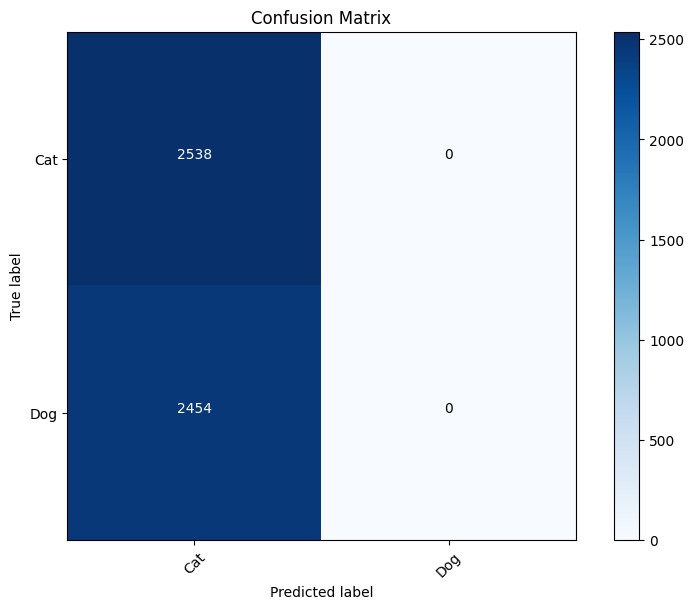

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

predictions = model.predict(test_generator)  # Reemplaza test_data con tus datos de prueba

# Convertir las predicciones de probabilidades a clases
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de datos de prueba
true_classes = np.argmax(test_labels, axis=1)  # Reemplaza test_labels con tus etiquetas verdaderas

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Definir las clases (etiquetas)
class_names = ['Cat', 'Dog'] 

# Mostrar la matriz de confusión
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()